In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

In [8]:
with open("run2.pkl", 'rb') as file:
    # Load the data from the pickle file
    din = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
        geometry = pickle.load(file)

In [9]:
def get_chIDs_by_layer(df, layer_number):
    ch_ids = []
    for ch_str in df[df['Layer'] == layer_number]['Ch#']:
        CAEN, ch = map(int, ch_str.split('-'))
        ch_id = ch + (64 * (CAEN - 1))
        ch_ids.append(ch_id)
    return ch_ids

In [10]:
def get_LG_array_by_layer(geometry, din):
    all_layers = sorted(geometry['Layer'].unique())
    layer_data = []

    for layer in all_layers:
        ch_ids = get_chIDs_by_layer(geometry, layer)
        combined = [din[f"{ID}_LG"] for ID in ch_ids if f"{ID}_LG" in din]
        if combined:
            layer_data.append(np.concatenate(combined))
        else:
            layer_data.append(np.array([]))  # empty array if no matches

    return layer_data

In [11]:
layer_arrays = get_LG_array_by_layer(geometry, din)

In [12]:
def plot_layer_histograms(layer_arrays, bins=200, range_=(0, 5000)):
    fig, axes = plt.subplots(5, 3, figsize=(15, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, data in enumerate(layer_arrays):
        if len(data) == 0:
            continue  # Skip empty layers
        counts, bin_edges = np.histogram(data, bins=bins, range=range_)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts)

        axes[i].errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {i}')
        #axes[i].set_title(f'Layer {i}')
        axes[i].legend()
        axes[i].set_yscale("log")
        axes[i].set_ylim(10,4000)

    for ax in axes[-5:]:  # Bottom row (x-axis label)
        ax.set_xlabel("ADC", fontsize=20)
    
    for ax in axes[::3]:  # Left column (y-axis label)
        ax.set_ylabel("Count", fontsize=20)
        
    fig.suptitle("Beam On LG Hits", fontsize=26, y=1.0)
    plt.tight_layout(pad=0.0)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

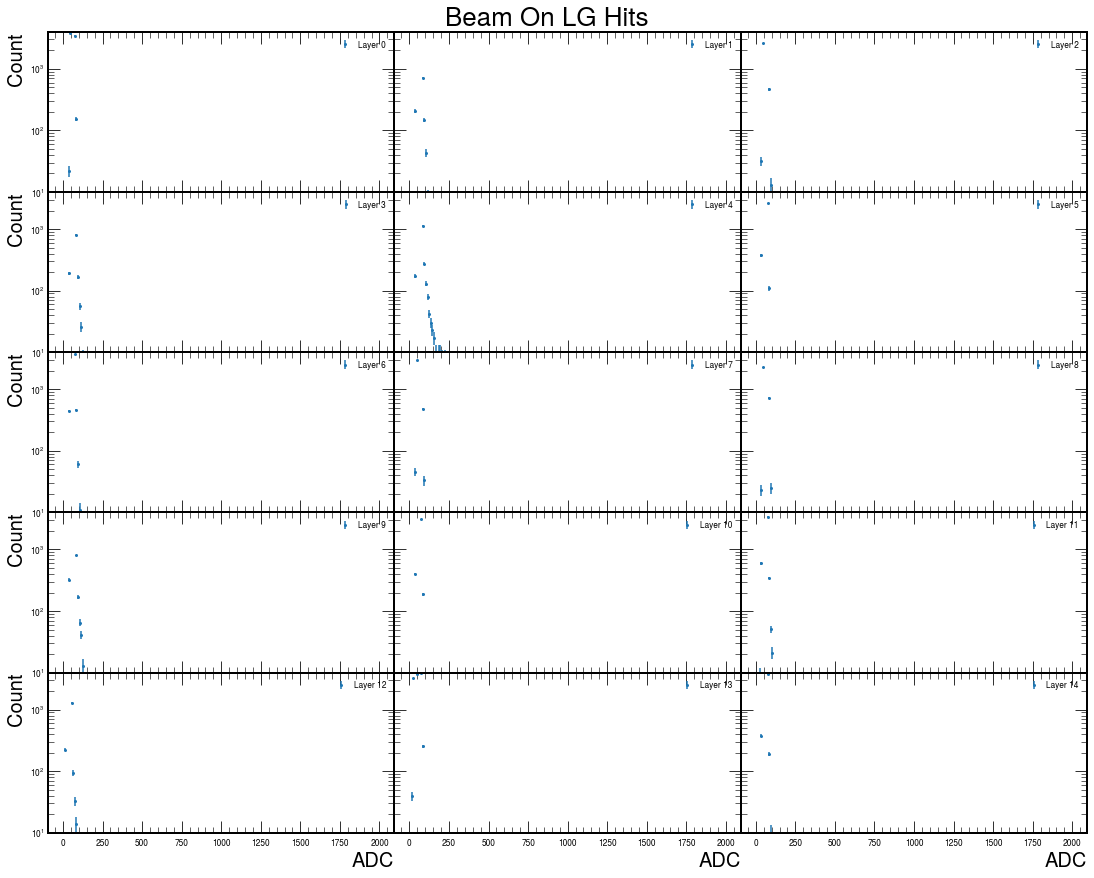

In [13]:
plot_layer_histograms(layer_arrays, bins=200, range_=(0, 2000))

In [14]:
def plot_channel_histograms_by_layer(geometry, din, layer, bins=200, range_=(0, 5000)):
    ch_ids = get_chIDs_by_layer(geometry, layer)

    fig, axes = plt.subplots(5, 5, figsize=(15, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, ch_id in enumerate(ch_ids):
        key = f"{ch_id}_LG"
        ax = axes[i]

        if key not in din or len(din[key]) == 0:
            ax.axis("off")
            continue

        data = np.array(din[key])
        counts, bin_edges = np.histogram(data, bins=bins, range=range_)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts)

        ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f"chID {ch_id}")
        ax.set_yscale("log")
        ax.set_ylim(10, 4000)
        ax.legend()
        

    # Turn off any unused axes if fewer than 25
    for j in range(len(ch_ids), 25):
        axes[j].axis("off")
    for ax in axes[-5:]:  # Bottom row (x-axis label)
        ax.set_xlabel("ADC", fontsize=20)
    
    for ax in axes[::5]:  # Left column (y-axis label)
        ax.set_ylabel("Count", fontsize=20)
    fig.suptitle(f"Layer {layer} - LG Hits", fontsize=26, y=0.95)

    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.show()


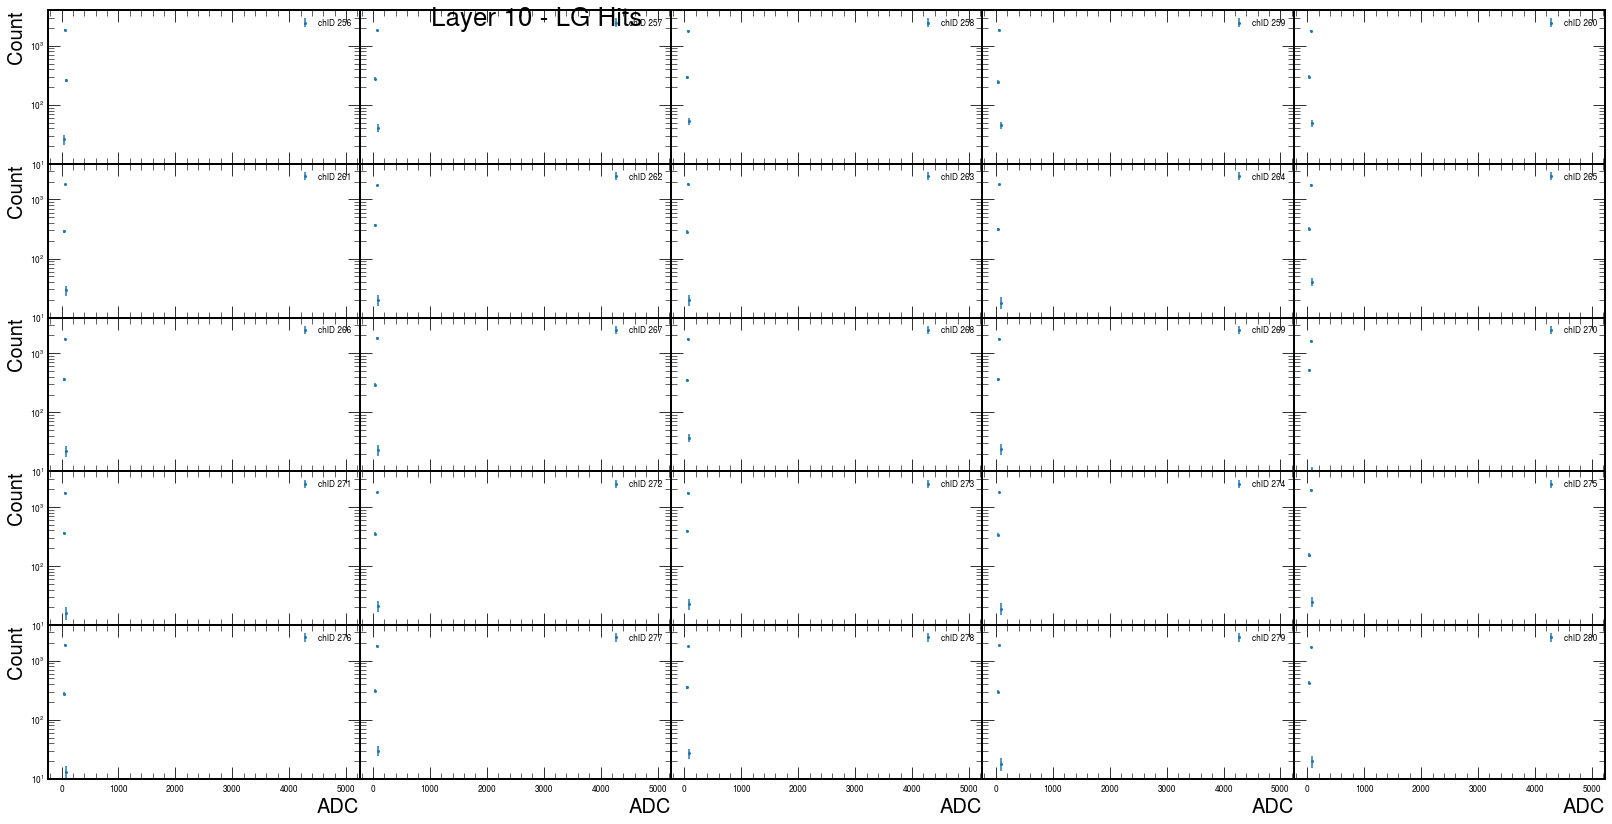

In [17]:
plot_channel_histograms_by_layer(geometry, din, 10, bins=200, range_=(0, 5000))